# CMMN (Convolutional Monge Mapping Normalization) Visualization

This notebook visualizes the pre-computed CMMN domain adaptation results for EEG signals.

All data has been pre-processed on HPC. This notebook only loads and visualizes:
- Pre-computed filters
- Pre-computed PSDs (raw and transformed)
- Barycenters

No raw data loading or transformations are performed here to minimize resource usage. In practice, we've used HPC for this due to high memory requirements, as we load the whole dataset into memory to compute transformations and filters. In practice, CPU only jobs with a large deal of RAM (~128 gb) are enough; no GPU is required for our CMMN functions.

In [1]:
# Set OMP constants to use only 8 CPUs
import os
os.environ["OMP_NUM_THREADS"] = "8"

In [2]:
# Imports
import sys
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Add parent directory to path for icwaves imports
sys.path.append('..')

# Import CMMN visualization functions from the new module
from icwaves.cmmn import (
    plot_psd,
    plot_barycenter,
    plot_freq_filter,
)

## Setup Paths and Parameters

In [3]:
# Subject lists
emotion_subj_list = [f'{i:02d}' for i in range(1, 36) if i != 22]  # 01-35 minus 22. Subject 22 is missing from the original dataset.
cue_subj_list = [f'{i:02d}' for i in range(1, 13)]  # 01-12

print(f"Will process {len(emotion_subj_list)} emotion subjects and {len(cue_subj_list)} cue subjects")

Will process 34 emotion subjects and 12 cue subjects


In [4]:
# Data paths with new organized structure
data_dir = Path('../data/filters_and_psds')

# PSDs paths
emotion_raw_psd_filepath = data_dir / 'emotion' / 'psds'
cue_raw_psd_filepath = data_dir / 'cue' / 'psds'

# Barycenter path
emotion_barycenter_filepath = data_dir / 'emotion' / 'barycenters'

# Filter paths  
cue_barycenter_filters_filepath = data_dir / 'cue' / 'cmmn_filters' / 'barycenter_mapping'
cue_subj_subj_filters_filepath = data_dir / 'cue' / 'cmmn_filters' / 'subj_to_subj'

## Load Pre-computed PSDs

In [5]:
# Load raw PSDs
emotion_data_psds_raw = []
cue_data_psds_raw = []

if emotion_raw_psd_filepath.exists():
    for subj in emotion_subj_list:
        psd_file = emotion_raw_psd_filepath / f'subj-{subj}_psds.npz'
        if psd_file.exists():
            emotion_data_psds_raw.append(np.load(psd_file)['arr_0'])

if cue_raw_psd_filepath.exists():
    for subj in cue_subj_list:
        psd_file = cue_raw_psd_filepath / f'cue_extract_{subj}_256_hz_psds.npz'
        if psd_file.exists():
            cue_data_psds_raw.append(np.load(psd_file)['arr_0'])

print(f"Loaded {len(emotion_data_psds_raw)} raw emotion PSDs and {len(cue_data_psds_raw)} raw cue PSDs")

Loaded 34 raw emotion PSDs and 12 raw cue PSDs


## 1. Raw PSDs - Emotion Dataset

Saved plot to cmmn_figures/emotion_raw_psds.pdf


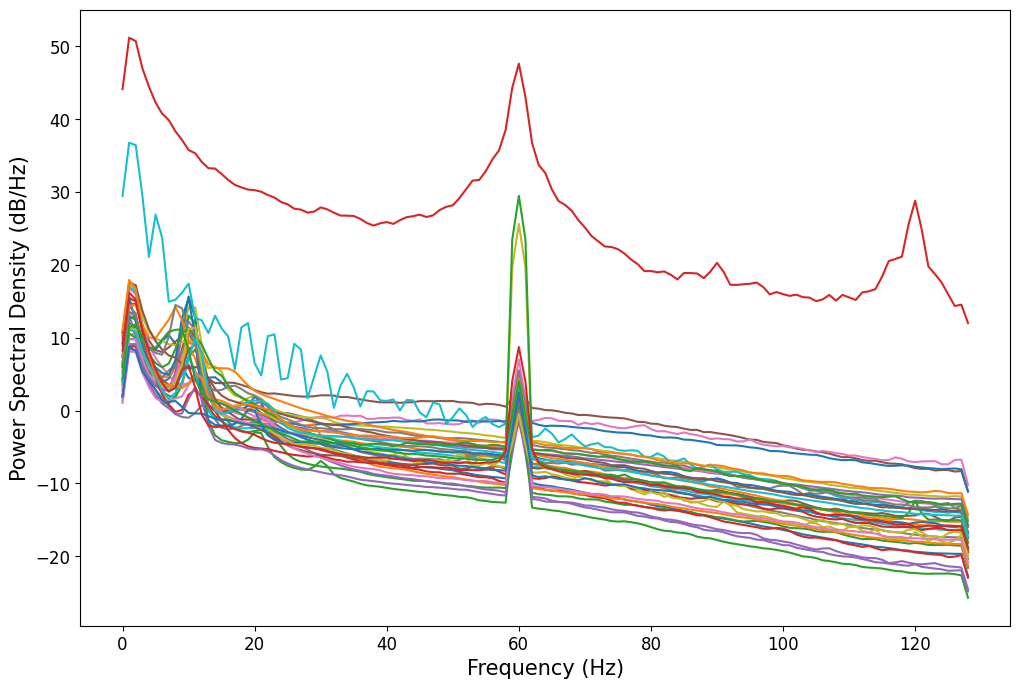

In [6]:
# Plot raw PSDs for emotion
if emotion_data_psds_raw:
    plot_psd(emotion_data_psds_raw, psds=emotion_data_psds_raw,
             title='Emotion Data, Unnormalized PSDs',
             save_path='cmmn_figures/emotion_raw_psds.pdf')

## 2. Raw PSDs - Cue Dataset

Saved plot to cmmn_figures/cue_raw_psds.pdf


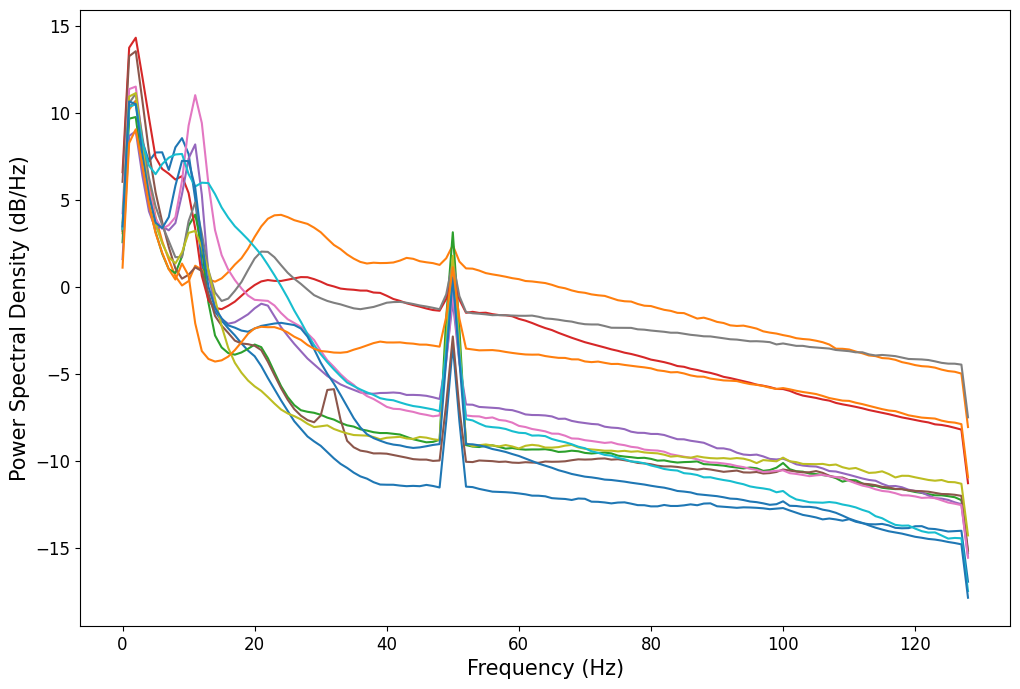

In [7]:
# Plot raw PSDs for cue
if cue_data_psds_raw:
    plot_psd(cue_data_psds_raw, psds=cue_data_psds_raw,
             title='Cue Data, Unnormalized PSDs',
             save_path='cmmn_figures/cue_raw_psds.pdf')

## 3. Barycenter Visualization

Saved plot to cmmn_figures/emotion_barycenter.pdf


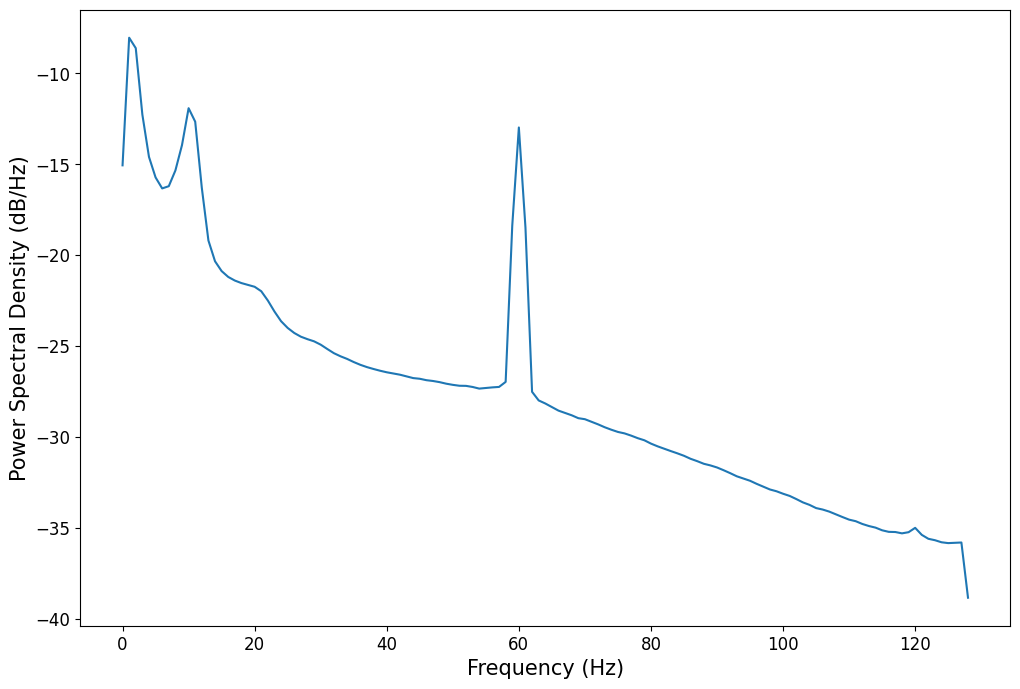

In [8]:
# Load and plot normed barycenter for emotion
barycenter_file = emotion_barycenter_filepath / 'emotion_normed_ch_avg_barycenter.npz'
if barycenter_file.exists():
    normed_emotion_barycenter = np.load(barycenter_file)['arr_0']
    plot_barycenter(normed_emotion_barycenter, 
                    title='Normalized Emotion Barycenter',
                    save_path='cmmn_figures/emotion_barycenter.pdf')
else:
    print(f"Barycenter file not found: {barycenter_file}")

## 4. Frequency Filters - Cue Dataset (Barycenter Mapping)

In [9]:
# Load cue frequency filters for both regimes
cue_original_freq_filters = []
cue_subj_subj_freq_filters = []

for subj in cue_subj_list:
    # Barycenter mapping filters
    barycenter_filter_path = cue_barycenter_filters_filepath / f'cue_original_ch_avg_barycenter_freq_filter_{subj}.npz'
    if barycenter_filter_path.exists():
        cue_original_freq_filters.append(np.load(barycenter_filter_path)['arr_0'])
    
    # Subject-to-subject filters
    subj_filter_path = cue_subj_subj_filters_filepath / f'cue_subj_subj_ch_avg_barycenter_freq_filter_{subj}.npz'
    if subj_filter_path.exists():
        cue_subj_subj_freq_filters.append(np.load(subj_filter_path)['arr_0'])

print(f"Loaded cue filters:")
print(f"  - Barycenter mapping: {len(cue_original_freq_filters)} frequency filters")
print(f"  - Subject-to-subject mapping: {len(cue_subj_subj_freq_filters)} frequency filters")

Loaded cue filters:
  - Barycenter mapping: 12 frequency filters
  - Subject-to-subject mapping: 12 frequency filters


Saved plot to cmmn_figures/cue_barycenter_freq_filters.pdf


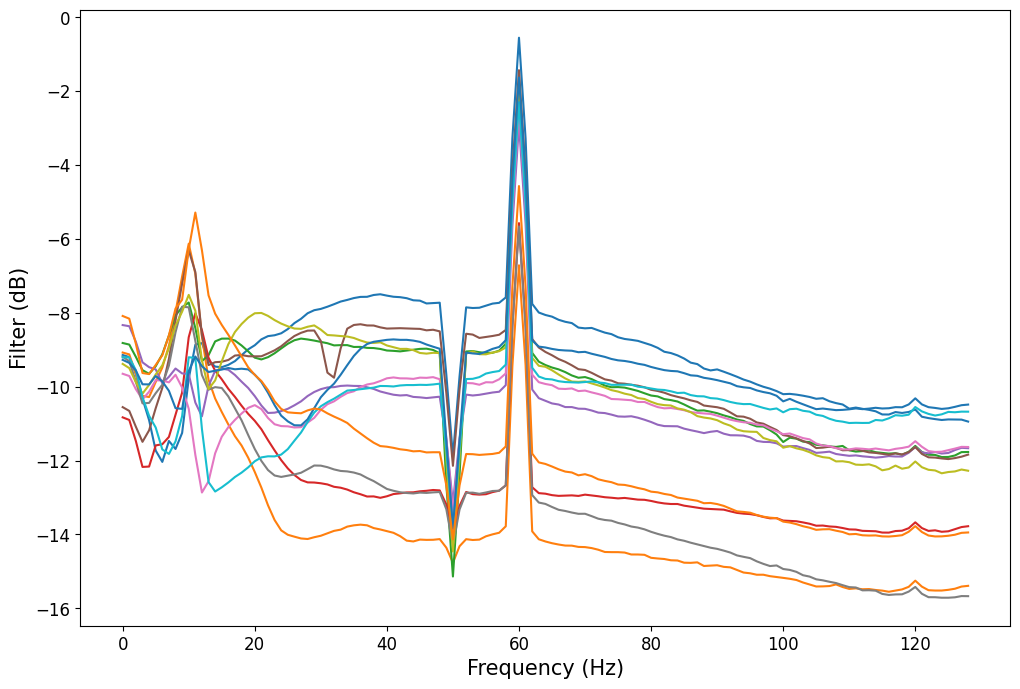

In [10]:
# Visualize cue frequency filters - barycenter mapping
if cue_original_freq_filters:
    plot_freq_filter(cue_original_freq_filters, 
                    title='Cue Barycenter Mapping Frequency Filters',
                    save_path='cmmn_figures/cue_barycenter_freq_filters.pdf')

## 5. Frequency Filters - Cue Dataset (Subject-to-Subject Mapping)

Saved plot to cmmn_figures/cue_subj_subj_freq_filters.pdf


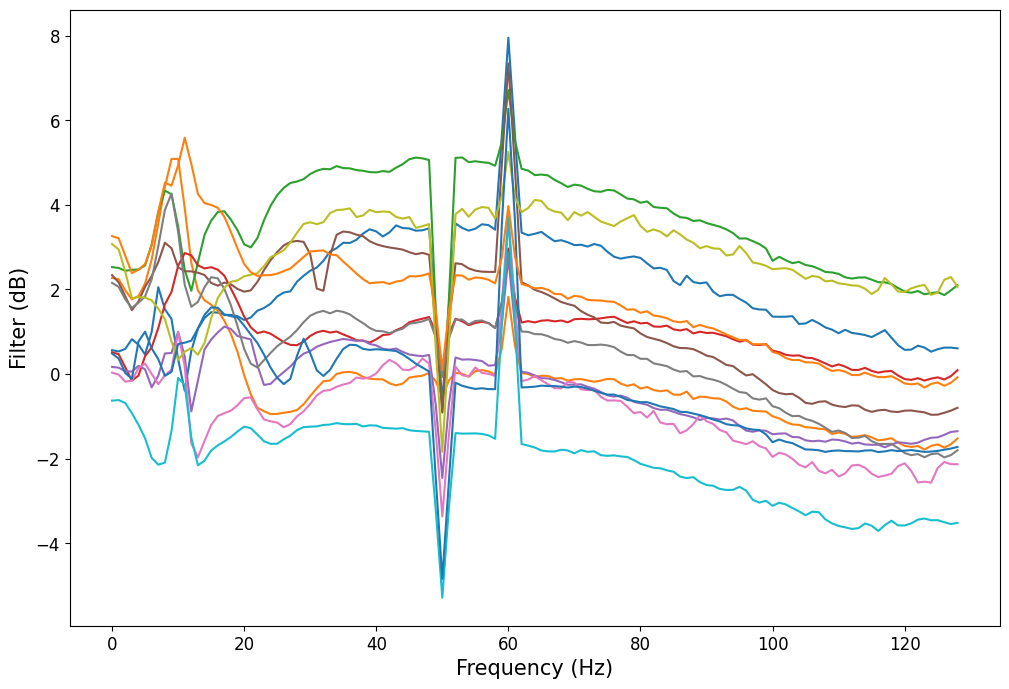

In [11]:
# Visualize cue frequency filters - subject-to-subject
if cue_subj_subj_freq_filters:
    plot_freq_filter(cue_subj_subj_freq_filters, 
                    title='Cue Subj-to-subj Mapping Frequency Filters',
                    save_path='cmmn_figures/cue_subj_subj_freq_filters.pdf')

In [12]:
print("\n" + "="*60)
print("CMMN VISUALIZATION COMPLETE!")
print("="*60)
print(f"\nData processed:")
print(f"  - {len(emotion_subj_list)} emotion subjects")
print(f"  - {len(cue_subj_list)} cue subjects")

print(f"\nFilters loaded:")
print(f"  - Cue → Emotion (barycenter): {len(cue_original_freq_filters)} subjects")
print(f"  - Cue → Emotion (subj-to-subj): {len(cue_subj_subj_freq_filters)} subjects")

print(f"\nVisualizations:")
print(f"  1. Raw PSDs - Emotion: {len(emotion_data_psds_raw)} subjects")
print(f"  2. Raw PSDs - Cue: {len(cue_data_psds_raw)} subjects")
print(f"  3. Barycenter: Normalized emotion barycenter")
print(f"  4. Cue Filters (barycenter): {len(cue_original_freq_filters)} frequency filters")
print(f"  5. Cue Filters (subj-to-subj): {len(cue_subj_subj_freq_filters)} frequency filters")


CMMN VISUALIZATION COMPLETE!

Data processed:
  - 34 emotion subjects
  - 12 cue subjects

Filters loaded:
  - Cue → Emotion (barycenter): 12 subjects
  - Cue → Emotion (subj-to-subj): 12 subjects

Visualizations:
  1. Raw PSDs - Emotion: 34 subjects
  2. Raw PSDs - Cue: 12 subjects
  3. Barycenter: Normalized emotion barycenter
  4. Cue Filters (barycenter): 12 frequency filters
  5. Cue Filters (subj-to-subj): 12 frequency filters
